<h1>LagGenius Technical Exercise</h1>

 **Author: Ana Valinhas**
<h2>Introduction</h2>

LabGenius Project Alpha Team is focused on the Development of a developable, potent and selective T-cell engager. The optimization team is responsible for building the protein, the antibody team tests the developability of the protein, and the assay team tests the function of the protein.

<h2>Objectives</h2>

-	Prepare a report to summarize the findings taken from a dataset obtained in 4 design-build-test-learn cycles.
-	Propose a method for the project team to design cycle 5 to improve potency, selectivity and developability.

<h2>Results</h2>
<h3>Description of the Dataset</h3>

The provided dataset contains data from 4 cycles, with a total of 3012 datapoints. There are 751, 752, 756, and 753 datapoints for cycle 1, cycle 2, cycle 3, and cycle 4 respectively.

The dataset contains 5 features:

-	**feature_1**: categorical data with values A, B, C, D, E
-	**feature_2**: categorical data with values F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z
-	**feature_3**: categorical data with values Y, Z
-	**feature_4**: numerical data with values 1 to 20
-	**feature_5**: numerical data with values 1 to 10

The dataset contains 3 additional variables:

-	**potency_log_m (Potency LogEC50)**: Potency of the molecule in a cancer cell line, reported as a numeric log molar EC50 value. A smaller value here means a more potent molecule, as this means the molecule can effectively kill cancer cells at a low concentration.
-	**selectivity (Selectivity)**: Selectivity of the molecules to a cancer cell line compared to a healthy cell line.
-	**pass_developability_qc (Developability)**: Did the molecule pass key developability QC criteria? This is a binary column, 1 for pass and 0 for fail.

The proposed problem is a  multi-objective optimization problem where the objective is to maximize potency_log_m, selectivity and pass_developability_qc. The theoretical design space for the features provided is 42000 possible molecules given by the product of the number of possible options across all five features.


In [ ]:
%%writefile requirements.txt

pandas==2.2.3
seaborn==0.13.2
matplotlib==3.9.4
numpy==1.26.4
sklearn==1.6.0
scipy==1.13.1
ax-platform==0.3.7

In [ ]:
!pip install -r requirements.txt

In [179]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import numpy as np
from ax.service.ax_client import AxClient, ObjectiveProperties

class PlotResultsController():
    '''visualizations will be defined in this class'''
    @classmethod
    def plot_histograms(cls, data, list_variables, list_x_label, hue):
        fig, axes = plt.subplots(1, len(list_variables), figsize=(14, 6))
        for i in range(len(axes)):
            sns.histplot(data=data, x=list_variables[i], hue=hue, multiple='stack', kde=False, ax=axes[i])
            axes[i].set_title("Histogram of "+str(list_x_label[i])+" across "+str(hue))
            axes[i].set_xlabel(str(list_x_label[i]))
            axes[i].set_ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    @classmethod
    def plot_violin(cls, data, x_variable, x_label, list_y_variables, list_y_label):
        fig, axes = plt.subplots(1, len(list_y_variables), figsize=(14, 6))
        for i in range(len(axes)):
            sns.violinplot(x=x_variable, y=list_y_variables[i], data=data, color='lightpink', ax=axes[i])
            axes[i].set_title("Violin Plot for "+str(list_y_label[i])+" across "+str(x_label))
            axes[i].set_xlabel(x_label)
            axes[i].set_ylabel(list_y_label[i])
        plt.tight_layout()
        plt.show()
    
    @classmethod
    def plot_barchart(cls, x, y, data, title, xlabel, ylabel, text=True):
        sns.set(style="whitegrid")
        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x=x, y=y, data=data, color='lightpink')
        if text is True:
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x() + p.get_width() / 2, height*1.01, f'{height:.2f}',
                        ha="center", va="center", fontsize=10, color='black', fontweight='bold', 
                        verticalalignment='bottom')  # Position the value at the top of each bar
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

class ModelsToUse():
    '''Methods for modelling responses'''
    @classmethod
    def random_forest_classifier(cls, X, y, test_size, response_name):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=encoded_data['cycle'])
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        
        feature_importance = rf_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        })
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        plot_barchart('Feature','Importance', importance_df, 'Feature Importance in Random Forest Classification for '+str(response_name), 'Feature', 'Importance')

    @classmethod
    def random_forest_regression(cls, X, y, test_size, response_name):
        #randomForest Regression potency
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X.select_dtypes(include=['float64', 'int64', 'int32'])), 
                                columns=X.select_dtypes(include=['float64', 'int64', 'int32']).columns)
        X_scaled = pd.concat([X_scaled, X.select_dtypes(include=['category', 'object'])], axis=1)
        X_scaled = X_scaled.fillna(0)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"Mean Squared Error: {mse}")
        print(f"R² Score: {r2}")
        feature_importance = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        })
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        plot_barchart('Feature','Importance', importance_df, 'Feature Importance in Random Forest Regression for '+str(response_name), 'Feature', 'Importance')



In [185]:
data = pd.read_csv(r'C:\Users\ana.valinhas\OneDrive - MeiraGTx LLC\Documents\labgenius_case study\dataset.csv', header=0)
print("\nNumber of experiments "+str(len(data)))
number_exp_per_cycle = data.copy()
number_exp_per_cycle = number_exp_per_cycle.groupby(['cycle']).count()    
print("\nNumber of experiments per cycle "+str(list(number_exp_per_cycle['feature_1'])))


Number of experiments 3012

Number of experiments per cycle [751, 752, 756, 753]


<h3>Question 1: Developability</h3>
Lower than expected developability rates were observed across 4 cycles and the team would like to understand what is driving this issue. 
What are the features which have a significant relationship to pass_developability_qc, and which statistical tests or models can be used to assess this relationship?

The barchart bellow shows the pass rate (%) for each cycle.  The pass rate for developability  was calculated as follows:

Pass rate (%) = Number of experiments that pass developability qc*100 / total number of experiments

The pass rate (%) for cycle 1 was of 54.33% and decreased to 50.86% for cycle 4.


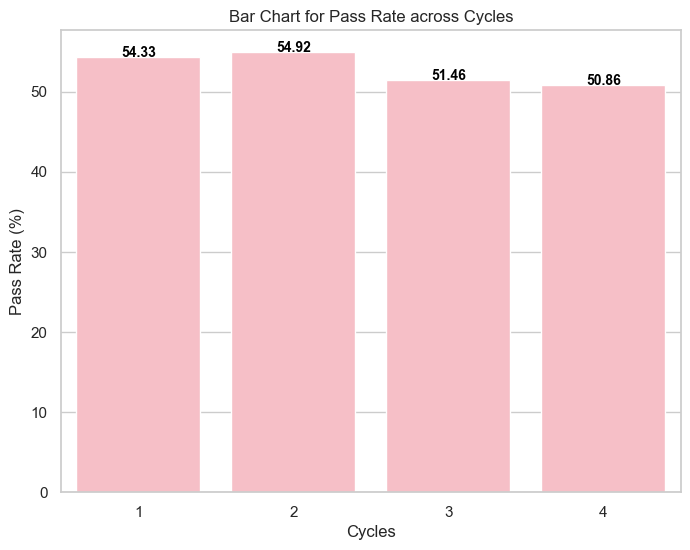

In [85]:
dev_pass_rate_data = data.copy()
dev_pass_rate_data = dev_pass_rate_data[['cycle', 'pass_developability_qc']]
dev_pass_rate_data = dev_pass_rate_data.groupby(['cycle','pass_developability_qc']).agg(pass_count=('pass_developability_qc', 'count')).reset_index()
dev_pass_rate_data = dev_pass_rate_data.pivot(index='cycle', columns='pass_developability_qc', values='pass_count').reset_index()
dev_pass_rate_data.columns=['cycle', 'fail_count', 'pass_count']
dev_pass_rate_data['pass_rate'] = dev_pass_rate_data['pass_count']*100/(dev_pass_rate_data['pass_count']+dev_pass_rate_data['fail_count'])
PlotResultsController.plot_barchart('cycle', 'pass_rate', dev_pass_rate_data, 'Bar Chart for Pass Rate across Cycles', 'Cycles', 'Pass Rate (%)')

The pass rate (%) was calculated for each feature. The barcharts bellow shows feature_1 and feature_5 led have the highest effect in pass rate (%). When feature_1 is set to D the pass rate (%) decreases up to three times. When feature_5 is set to 7, 8, 9 or 10, the pass rate (%) decreases up to five times.

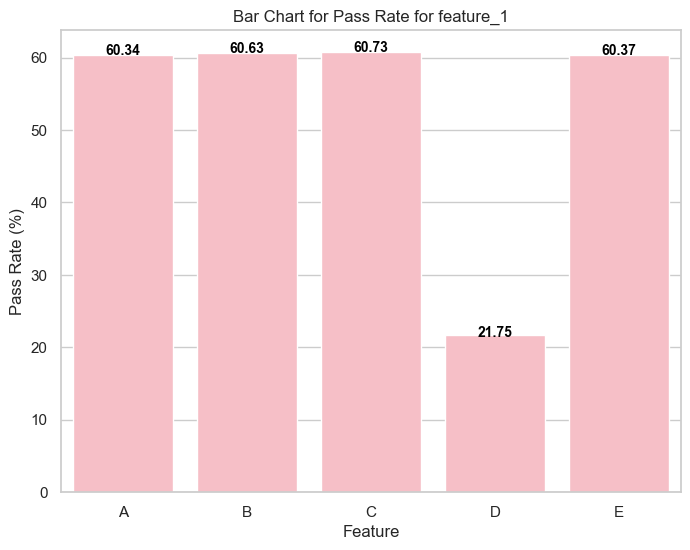

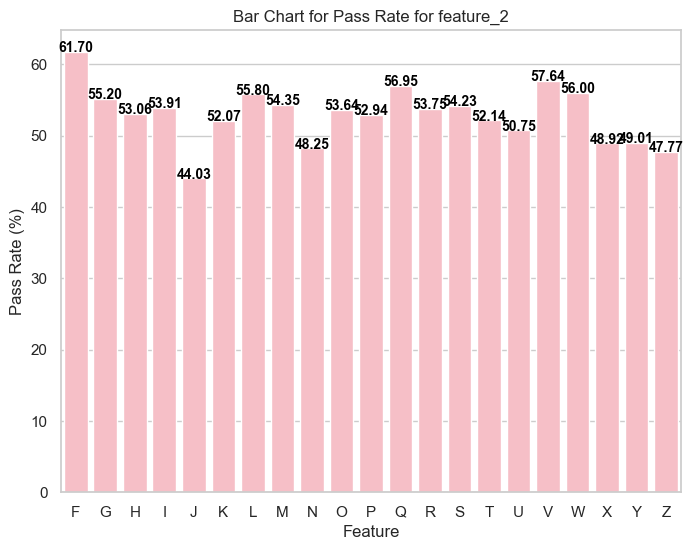

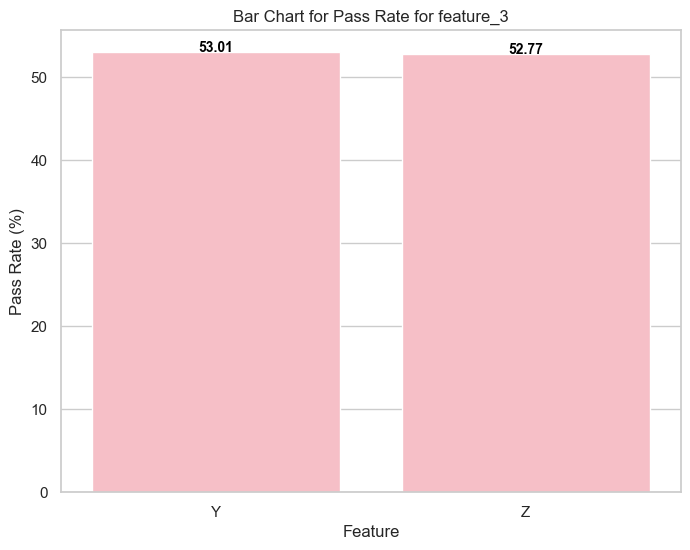

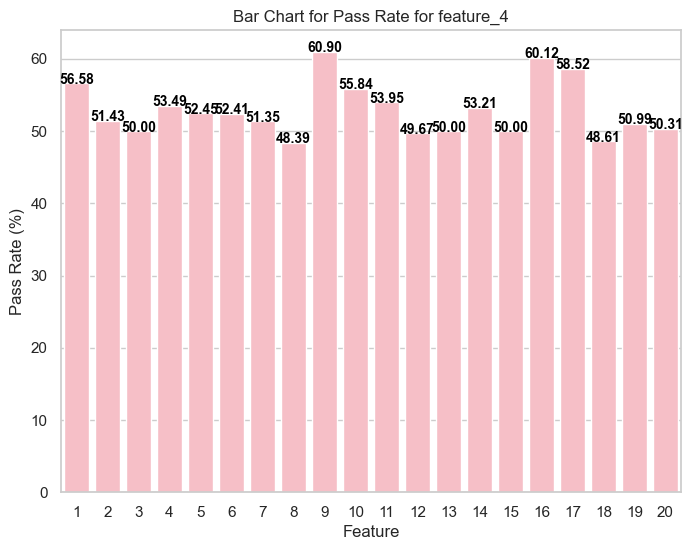

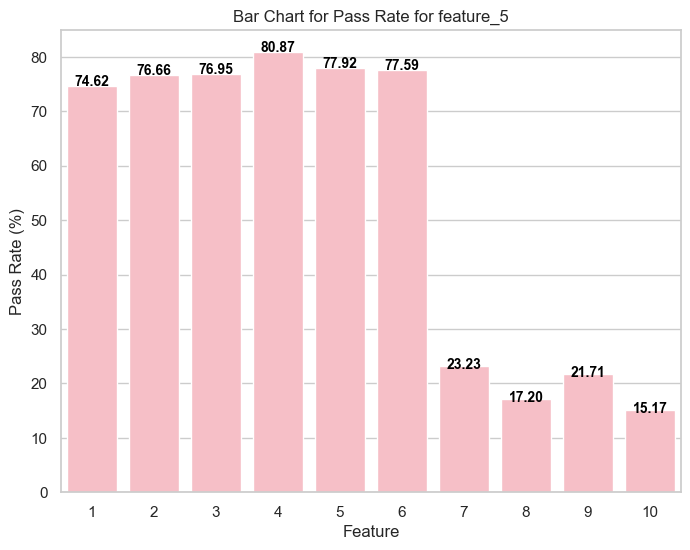

In [49]:
data_feature = data.copy()
list_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
for feature in list_features:
    data_feature = data.groupby([feature,'pass_developability_qc']).agg(pass_count=('pass_developability_qc', 'count')).reset_index()
    data_feature = data_feature.pivot(index=feature, columns='pass_developability_qc', values='pass_count').reset_index()
    data_feature.columns = [feature, 'fail_count', 'pass_count']
    data_feature['pass_rate'] = data_feature['pass_count']*100/(data_feature['pass_count']+data_feature['fail_count'])
    PlotResultsController.plot_barchart(feature, 'pass_rate', data_feature, 'Bar Chart for Pass Rate for ' +str(feature), 'Feature', 'Pass Rate (%)')

The relationship between features and pass_developability_qc can be verified by modelling the dataset. After encoding the data to account for categorical features, a random forest classifier was generated with train-test-split of 80 to 20. The classification report bellow shows that an accuracy of 0.82 was obtained. As expected, feature importance analysis reveals that feature_5 is the most important feature contributing to the prediction of pass_developability_qc followed by feature_1.

Accuracy: 0.8259

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82       272
           1       0.88      0.79      0.83       331

    accuracy                           0.83       603
   macro avg       0.83      0.83      0.83       603
weighted avg       0.83      0.83      0.83       603



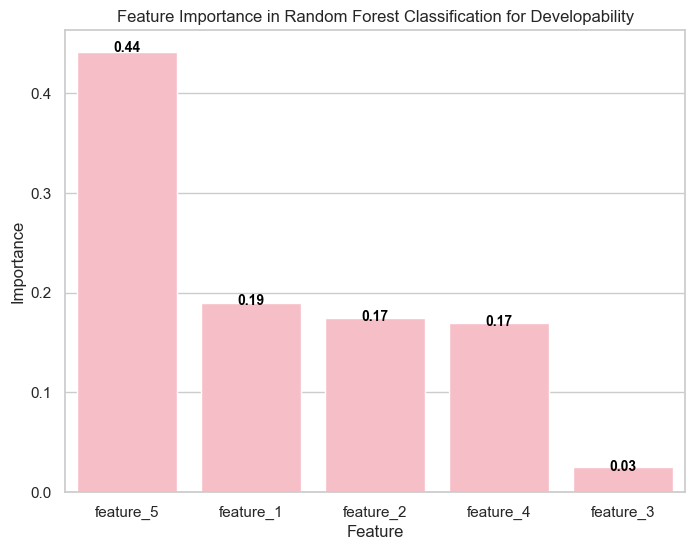

In [139]:
#encoding feature_1, feature_2 and feature_3
columns = ['feature_1', 'feature_2', 'feature_3']
encoded_data = data.copy()
label_encoders = {}
for column in columns:
    label_encoder=LabelEncoder()
    label_encoders[column] = label_encoder
    encoded_data[column] = label_encoder.fit_transform(data[column])
    label_mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}
    
#RandomForest Classifier
X = encoded_data[list_features]
y = encoded_data['pass_developability_qc']
ModelsToUse.random_forest_classifier(X, y, 0.2, 'Developability')

Furthermore, correlation analysis was performed to understand relationships between features, potency_log_m, selectivity, and pass_developability_qc. The methods utilized to check for correlation were the spearman correlation coefficient (non-linear correlation) and pearson correlation coefficient (linear correlations). Results are presented in the heatmaps bellow. Similar correlation matrices were obtained for both methods. The correlation matrices reveal that feature_5 is negatively correlated with pass_developability_qc. Feature_1 is also negatively correlated with pass_developability_qc, although not as strongly as feature_5. Another interesting finding is that feature_5 is positively correlated with selectivity, suggesting there is a trade-off between pass_developability_qc and selectivity which is strongly driven by feature.

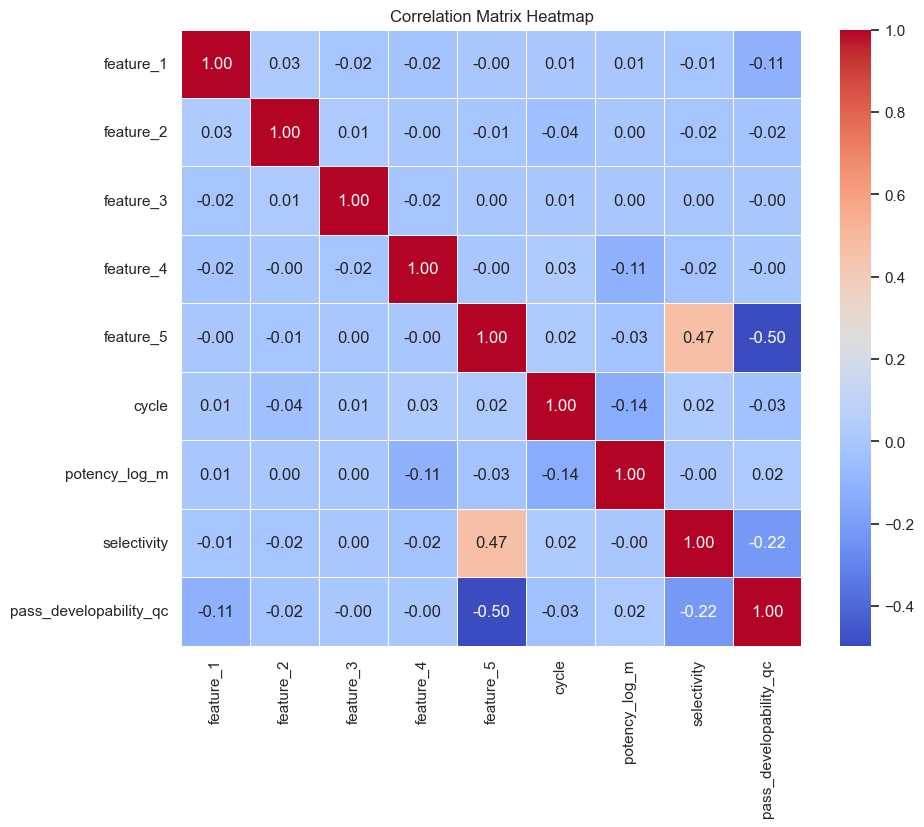

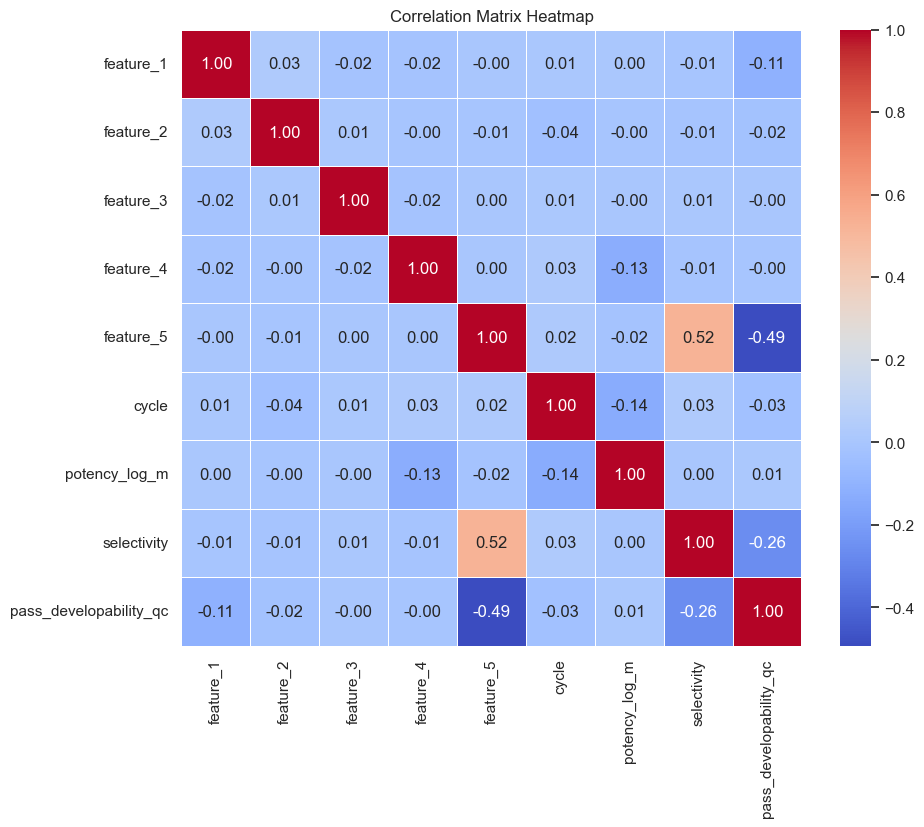

In [73]:
#Correlation between features
correlation_matrix_spearman = encoded_data.corr(method='spearman')
correlation_matrix_pearson = encoded_data.corr(method='pearson')

list_corr_matrices = [correlation_matrix_spearman, correlation_matrix_pearson]
for matrix in list_corr_matrices:
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

<h3>Question 2: Potency and Selectivity</h3>

A summary is presented for potency and selectivity data accumulated over 4 cycles.

The histogram for selectivity shows a mean close to zero and has a tail towards high selectivity. This is also evident in the violin plot which shows equal selectivity across cycles with a large standard deviation. The improvements in selectivity are mild across cycles, with a wide distribution. As observed in the correlation matrices, there is a trade-off between selectivity and pass_developability_qc when chaning feature 5, which could be driving these results.

The distribution of potency across cycles shows a shift  towards lower values of Potency LogEC50 from cycle 1 to cycle 3. However, the last cycle shows an increase in the Potency LogEC50 values, which indicates that the potency of constructs decreased on average from cycle 3 to cycle 4. This is also seen in the violin plot bellow which shows the average potency on cycle 3 shifting towards lower values of Potency LogEC50.


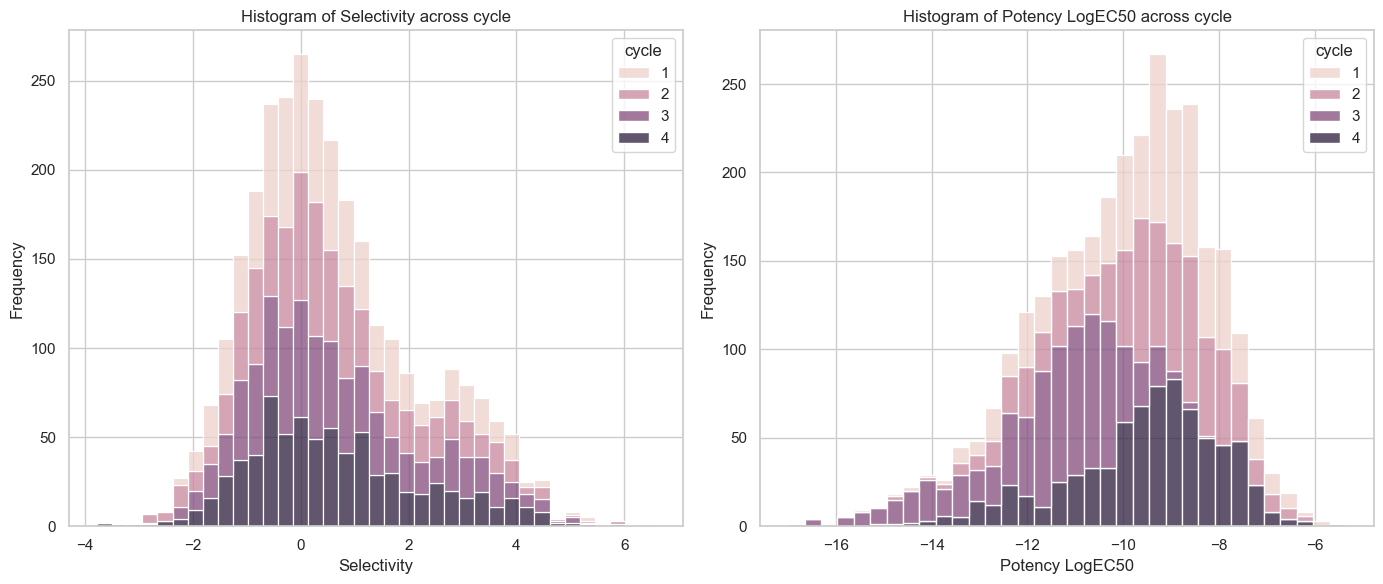

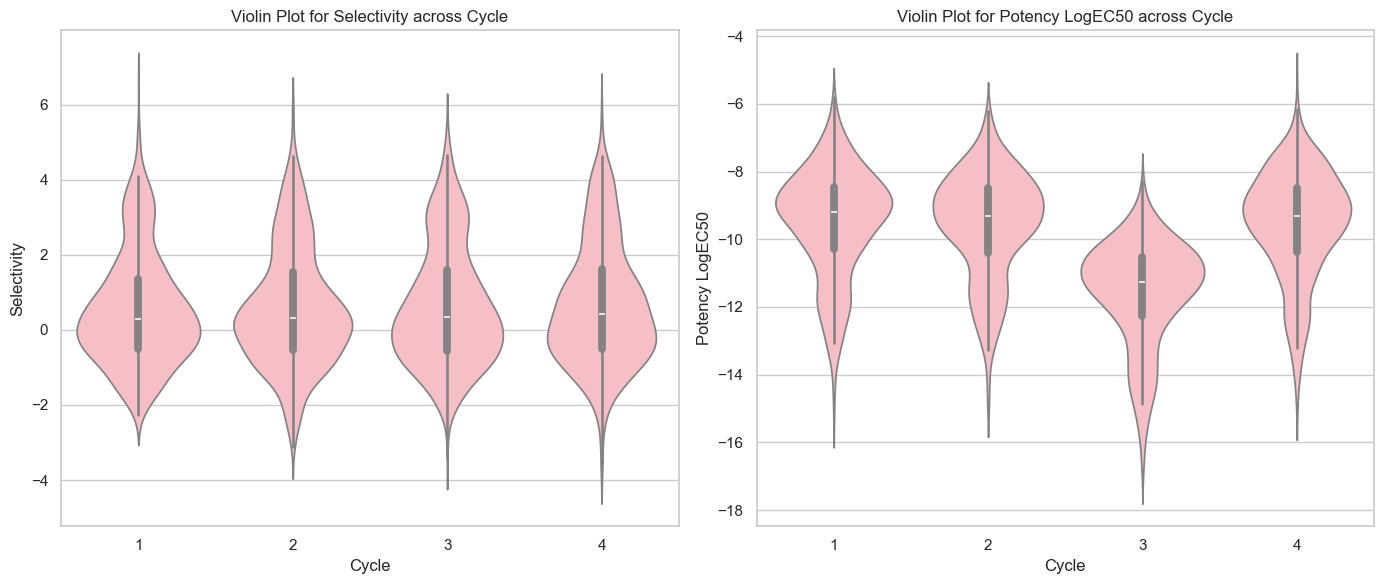

In [117]:
potency_selectivity_data = data.copy()
potency_selectivity_data = potency_selectivity_data[['cycle', 'potency_log_m', 'selectivity']]
PlotResultsController.plot_histograms(potency_selectivity_data, ['selectivity', 'potency_log_m'], ['Selectivity', 'Potency LogEC50'], 'cycle')
PlotResultsController.plot_violin(potency_selectivity_data, 'cycle', 'Cycle', ['selectivity', 'potency_log_m'], ['Selectivity', 'Potency LogEC50'])

A random forest regression model was generated to assess each features contribute the most selectivity. As shown bellow, feature_5 contributes the most to selectivity. The barplot bellow shows that setting feature_5 to 9 or 10 leads to maximization of selectivity.

Mean Squared Error: 1.1613253493777984
R² Score: 0.543797680562217


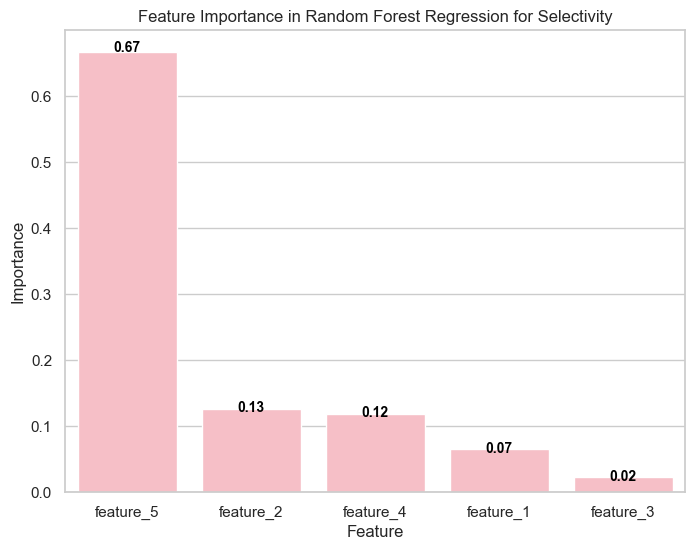

In [154]:
#randomForest Regression Selectivity
X = encoded_data[list_features]
y = encoded_data['selectivity']
ModelsToUse.random_forest_regression(X, y, 0.2, 'Selectivity')

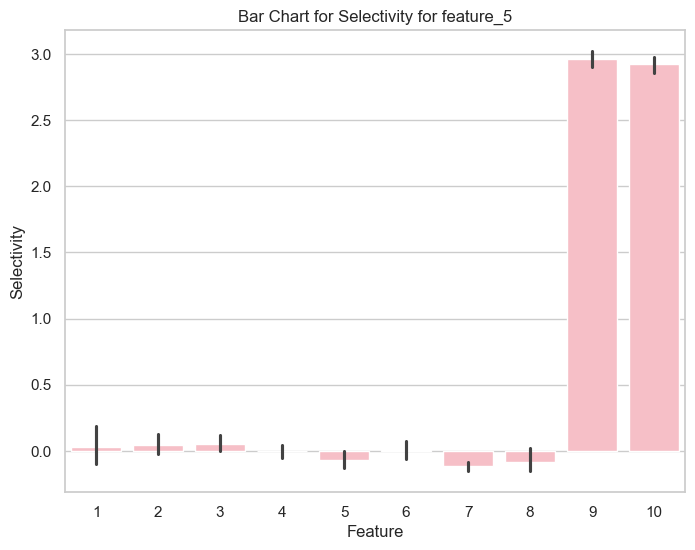

In [165]:
data_feature = data.copy()
data_feature = data.groupby(['feature_5','cycle']).agg(selectivity_mean=('selectivity', 'mean')).reset_index()
PlotResultsController.plot_barchart('feature_5', 'selectivity_mean', data_feature, 'Bar Chart for Selectivity for ' +str('feature_5'), 'Feature', 'Selectivity', text=False)

The shift in the distribution for potency in cycle 3 could mean that the potency assay is not performing as expected. To assess the performance of the assay, experimental points which are common between cycle 3 and all the other cycles were selected and visualized for potency_log_m in a scatter plot. Group ID is a label that groups experimental points which are equal across cycles. It is noticeable that there is a deviation towards higher potency in cycle 3 when compared to the same experimental points repeated in other cycles.

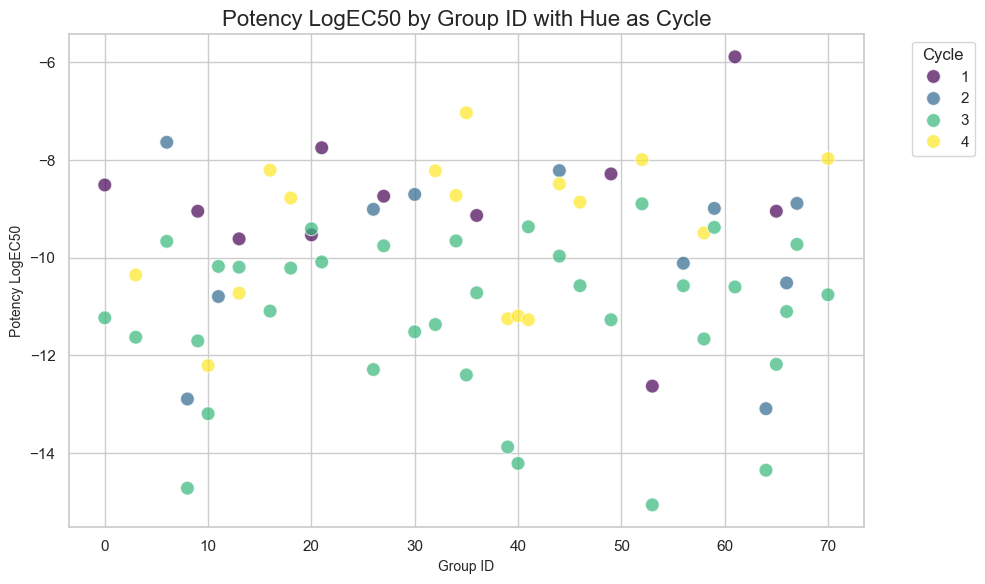

In [132]:
data_same = data.copy()
data_same = data_same[data_same.duplicated(subset=list_features, keep=False)].reset_index(drop=True)
data_same = data_same.sort_values(by=list_features)
data_same['group_id'] = data_same.groupby(list_features).ngroup()
groups_cycle_3 = list(data_same['group_id'].loc[data_same['cycle']==3])
data_same_exc_3 = data_same.loc[~data_same['group_id'].isin(groups_cycle_3)]
data_same_as_3 = data_same.loc[data_same['group_id'].isin(groups_cycle_3)]

#scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_same_as_3, x='group_id', y='potency_log_m', hue='cycle', palette='viridis', s=100, alpha=0.7)
plt.title("Potency LogEC50 by Group ID with Hue as Cycle", fontsize=16)
plt.xlabel("Group ID", fontsize=10)
plt.ylabel("Potency LogEC50", fontsize=10)
plt.legend(title='Cycle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


To further understand the impact of cycle 3 data on the prediction of potency, a random forest regression model was generated. When including data from cycle 3, the accuracy of the model is of 0.33, and increases to 0.52 when excluding data from this cycle. This indicates that including points from cycle 3 leads to a higher level of unexplained variance. A thorough investigation should be performed on the results obtained in the potency assay in cycle 3, to understand what may have caused this observed deviation to higher potency. Positive and negative controls should be assessed and compared with previous assay runs performed in other cycles of experimentation to assess sources of variability such as change in reagents, deviations in protocols, as well as biological variability of cells used in the assay. Since no other sources of information are available to perform root cause analysis to validate potency assay results in cycle 3, **it is recommended** that data from cycle 3 is not considered in the prediction of experiments to execute in cycle 5.

The random forest regression also reveral that featuer_4 is the feature that most explains Potency LogEC50. The barchart bellow shows that setting this feature to 5, 10, 15, or 20 leads to maximization of potency.

Random Forest Regression with data from all cycles
Mean Squared Error: 2.3559480123653196
R² Score: 0.33777020973952265


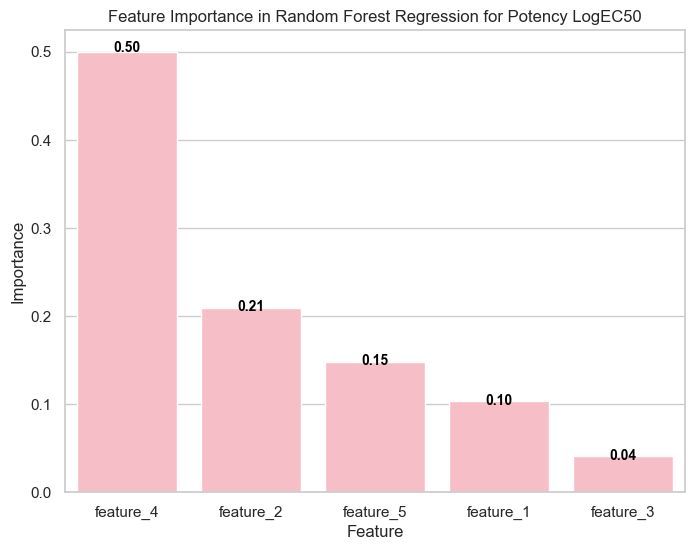

Random Forest Regression excluding data from Cycle 3
Mean Squared Error: 1.183810974705574
R² Score: 0.5171859960209739


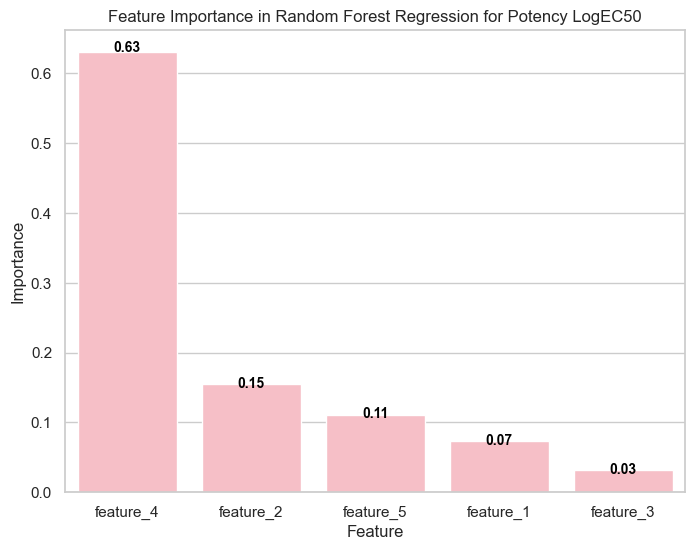

In [151]:
#randomForest Regression potency
print('Random Forest Regression with data from all cycles')
X = encoded_data[list_features]
y = encoded_data['potency_log_m']
ModelsToUse.random_forest_regression(X, y, 0.2, 'Potency LogEC50')

print('Random Forest Regression excluding data from Cycle 3')
subset_encoded_data = encoded_data.loc[encoded_data['cycle']!=3]
subset_encoded_data = subset_encoded_data.reset_index(drop=True)
X = subset_encoded_data[list_features]
y = subset_encoded_data['potency_log_m']
ModelsToUse.random_forest_regression(X, y, 0.2, 'Potency LogEC50')

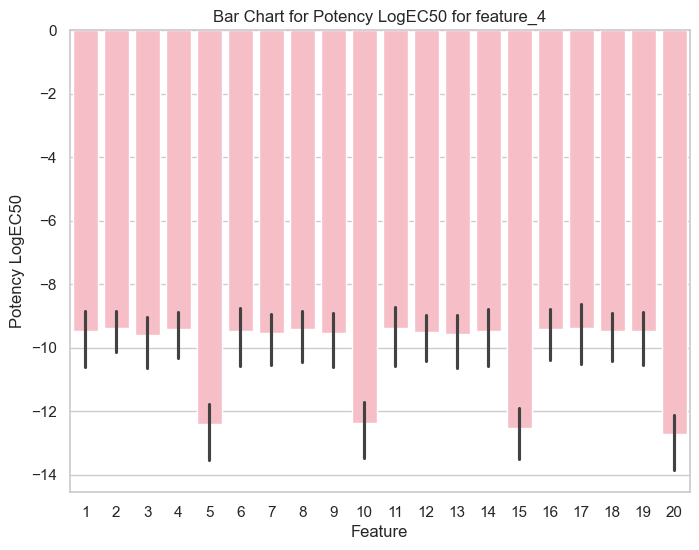

In [167]:
data_feature = data.copy()
data_feature = data.groupby(['feature_4','cycle']).agg(potency_mean=('potency_log_m', 'mean')).reset_index()
PlotResultsController.plot_barchart('feature_4', 'potency_mean', data_feature, 'Bar Chart for Potency LogEC50 for ' +str('feature_4'), 'Feature', 'Potency LogEC50', text=False)

<h3>Question 3: Design of Cycle 5</h3>

In summary, the following trends were observed:

-	Setting **feature_1** to D has a detrimental effect on pass_qc_developbality. This feature doesn’t s significantly affect selectivity and potency.
-	There is a **trade-off** between pass_developability_qc and selectivity driven by **feature_5**. Setting this variable to 7, 8, 9 or 10 leads to a detrimental impact in pass_qc_developability. Setting feature_5 to 9 or 10 leads to maximization of selectivity.
-	**feature_4** has the biggest effect on potency and maximizes this response when set to 5, 10, 15 or 20.
-	Potency results from **cycle 3** might present abnormal results that lead to reduced explainability of potency when included in the training of a random forest regression model.

The design for test cycle 5 can be obtained by implementing a multi-objective optimization experiment using Ax, a library developed by Facebook for adaptive experimentation and optimization. The random forest classifier built to precidict pass_developavility_qc, and the two random forest regression models developed for potency and selectivity were used as surrogate functions. The optimization function has the objective to maximize all 3 objectives. AxClient loops over data from cycles 1, 2, and 4 and attaches parameters values to an Ax experiment and the objective values are used to complete the trial. Finally, AxClient suggests 753 new experimental points to be assessed in cycle 5. From these 753 experimental points, 47 are repeated from previous cycles, which will be used as controls. The suggested 753 experiments can be found in **‘suggested_experiments_decoded.csv’**.


In [33]:
obj1_name = "developability"
obj2_name = "potency"
obj3_name = "selectivity"

list_features = ['feature_1', 'feature_2','feature_3', 'feature_4', 'feature_5']
encoded_data_cycle = encoded_data.copy()
encoded_data_cycle = encoded_data_cycle.loc[encoded_data_cycle['cycle']!=3]
for column in list_features:
   encoded_data_cycle[column]=encoded_data_cycle[column].astype(int)
features = encoded_data_cycle[list_features]

labels_developability =encoded_data_cycle['pass_developability_qc']
labels_potency = encoded_data_cycle['potency_log_m']             
labels_selectivity = encoded_data_cycle['selectivity']        

X_train, X_test, y_dev_train, y_dev_test = train_test_split(features, labels_developability, test_size=0.2, random_state=42)
_, _, y_pot_train, y_pot_test = train_test_split(features, labels_potency, test_size=0.2, random_state=42)
_, _, y_sel_train, y_sel_test = train_test_split(features, labels_selectivity, test_size=0.2, random_state=42)


rf_developability = RandomForestClassifier(n_estimators=100, random_state=42)
rf_developability.fit(X_train, y_dev_train)

rf_potency = RandomForestRegressor(n_estimators=100, random_state=42)
rf_potency.fit(X_train, y_pot_train)

rf_selectivity = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selectivity.fit(X_train, y_sel_train)

def evaluate_objectives(feature_1, feature_2, feature_3, feature_4, feature_5):
    """
    Evaluate developability (classification), potency (regression), and selectivity (regression)
    using trained Random Forest models.
    """
    input_features = pd.DataFrame(
        [[feature_1, feature_2, feature_3, feature_4, feature_5]],
        columns=["feature_1", "feature_2", "feature_3", "feature_4", "feature_5"]
    )

    developability = rf_developability.predict_proba(input_features)[:, 1][0]
    potency = rf_potency.predict(input_features)[0]
    selectivity = rf_selectivity.predict(input_features)[0]

    return {
        obj1_name: float(developability),  # Minimize the negative probability for class 1
        obj2_name: float(-potency),         # Minimize negative potency (equivalent to maximizing)
        obj3_name: float(selectivity),      # Minimize selectivity
    }


X_train_ax = features


y_train_ax = [
    evaluate_objectives(
        row["feature_1"], row["feature_2"], row["feature_3"], row["feature_4"], row["feature_5"]
    )
    for _, row in X_train_ax.iterrows()
]


ax_client = AxClient()


ax_client.create_experiment(
    parameters=[
        {"name": "feature_1", "type": "choice", "is_ordered": False, "values": [1, 4, 0, 2, 3]},
        {"name": "feature_2", "type": "choice", "is_ordered": False, "values": [12, 9, 17, 19, 4, 20, 7, 0, 1, 14, 13, 2, 8, 16, 18, 11, 10, 6, 15, 5, 3]},
        {"name": "feature_3", "type": "choice", "is_ordered": False, "values": [1, 0]},
        {"name": "feature_4", "type": "choice", "is_ordered": False, "values": [12, 18, 17, 2, 20, 1, 6, 19, 5, 4, 3, 13, 14, 10, 9, 11, 8, 16, 15, 7]},
        {"name": "feature_5", "type": "choice", "is_ordered": False, "values": [7, 10, 6, 4, 3, 1, 5, 2, 8, 9]},
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=False),
        obj2_name: ObjectiveProperties(minimize=True),
        obj3_name: ObjectiveProperties(minimize=False),
    },
)


for i in range(len(X_train_ax)):
    parameterization = X_train_ax.iloc[i].to_dict()
    ax_client.attach_trial(parameterization)
    ax_client.complete_trial(trial_index=i, raw_data=y_train_ax[i])

num_suggestions = 753
suggested_experiments = []

for _ in range(num_suggestions):
    parameterization, trial_index = ax_client.get_next_trial()
    suggested_experiments.append(parameterization)


experiments_df = pd.DataFrame()
print("Suggested experiments:")
for i, exp in enumerate(suggested_experiments, start=1):
    print(f"Experiment {i}: {exp}")
    exp_df = pd.DataFrame([exp])
    experiments_df = pd.concat([experiments_df, exp_df], ignore_index=True)
experiments_df.to_csv("suggested_experiments.csv", index=False)
print("\nFinal DataFrame with suggested experiments:")

feature_1                   int32
feature_2                   int32
feature_3                   int32
feature_4                   int32
feature_5                   int32
cycle                       int64
potency_log_m             float64
selectivity               float64
pass_developability_qc      int64
dtype: object


[INFO 12-18 13:25:21] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-18 13:25:21] ax.service.utils.instantiation: Due to non-specification, we will use the heuristic for selecting objective thresholds.
[INFO 12-18 13:25:21] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter feature_1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
C:\Users\ana.valinhas\Anaconda3\lib\site-packages\ax\core\parameter.py:594: UserWarning: `sort_values` is not specified for `ChoiceParameter` "feature_1". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
  warn(
[INFO 12-18 13:25:21] ax.service.utils.instanti

Suggested experiments:
Experiment 1: {'feature_1': 2, 'feature_2': 17, 'feature_3': 0, 'feature_4': 7, 'feature_5': 2}
Experiment 2: {'feature_1': 1, 'feature_2': 16, 'feature_3': 1, 'feature_4': 15, 'feature_5': 2}
Experiment 3: {'feature_1': 3, 'feature_2': 15, 'feature_3': 1, 'feature_4': 13, 'feature_5': 5}
Experiment 4: {'feature_1': 3, 'feature_2': 0, 'feature_3': 0, 'feature_4': 7, 'feature_5': 2}
Experiment 5: {'feature_1': 4, 'feature_2': 15, 'feature_3': 1, 'feature_4': 4, 'feature_5': 6}
Experiment 6: {'feature_1': 2, 'feature_2': 16, 'feature_3': 1, 'feature_4': 2, 'feature_5': 8}
Experiment 7: {'feature_1': 4, 'feature_2': 7, 'feature_3': 0, 'feature_4': 15, 'feature_5': 2}
Experiment 8: {'feature_1': 3, 'feature_2': 8, 'feature_3': 0, 'feature_4': 3, 'feature_5': 7}
Experiment 9: {'feature_1': 2, 'feature_2': 8, 'feature_3': 0, 'feature_4': 11, 'feature_5': 9}
Experiment 10: {'feature_1': 4, 'feature_2': 3, 'feature_3': 1, 'feature_4': 18, 'feature_5': 3}
Experiment 11: {

In [73]:
data_exp = pd.read_csv('suggested_experiments.csv', header=0)
for column in label_encoders:
    data_exp[column] = label_encoders[column].inverse_transform(data_exp[column])
data_exp.to_csv("suggested_experiments_decoded.csv", index=False)
repeated_rows_count = data_exp.duplicated().sum()
print(repeated_rows_count)
data_original = data.copy()
data_original = data_original[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'cycle']]
data_comparison = data_exp.merge(data_original, how='inner')
print(len(data_comparison))

0
48
